<a href="https://colab.research.google.com/github/GZabalaG/AIMaster/blob/main/borrador_3_trabajo_programacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto de programación

Gonzalo Zabala García

# Data loading
Kaggle api connection and dataset downloading

In [1]:
!pip install kaggle

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 74 bytes


In [3]:
!kaggle competitions download -c statoil-iceberg-classifier-challenge

train.json.7z: Skipping, found more recently modified local copy (use --force to force download)
test.json.7z: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.7z: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
!pip install pyunpack
!pip install patool

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
from pyunpack import Archive
# Para el presente trabajo exclusivamente utilizaremos los datos de 'train' etiquetados.
Archive('/content/train.json.7z').extractall("/content")
train_file = '/content/data/processed/train.json'

# Data exploration

In [7]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

In [8]:
# Lectura de los datos etiquetados de ENTRENAMIENTO
train = pd.read_json(train_file)
display(train[:5])

,id,band_1,band_2,inc_angle,is_iceberg
0,dfd5f913,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0
1,e25388fd,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0
2,58b2aaa0,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859,1
3,4cfc3a18,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",43.8306,0
4,271f93f4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",35.6256,0


In [9]:
train.describe()

,is_iceberg
count,1604.000000
mean,0.469451
std,0.499222
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [10]:
train.dtypes

id            object
band_1        object
band_2        object
inc_angle     object
is_iceberg     int64
dtype: object

In [11]:
train.isna().sum()

id            0
band_1        0
band_2        0
inc_angle     0
is_iceberg    0
dtype: int64

Be aware of inc_angle. It should be float. We got nulls values as *na* string. If we try to plot we receive an error saying it can't cast *na* values

In [12]:
null_inc_angle_train = train[(train['inc_angle']=='na')]['inc_angle'].count()
print('Number of na values in train: ', null_inc_angle_train)

Number of na values in train:  133


We're safe in test dataset.

These na values can be replaced according to some standard value like mean or median, or simply remove those rows.

The inc_angle is a very specific value that represents the incidence angle of which the image was taken.

Replacing this na values with mean could damage our dataset. The best option is to delete these rows. We've to be carefully with these operation because we'll delete more than 8% of the data

In [13]:
print('Mean', train[(train['inc_angle']!='na')]['inc_angle'].mean())
print('Max', train[(train['inc_angle']!='na')]['inc_angle'].max())
print('Min', train[(train['inc_angle']!='na')]['inc_angle'].min())
print('Median', train[(train['inc_angle']!='na')]['inc_angle'].median())
print('Mode', train[(train['inc_angle']!='na')]['inc_angle'].mode())

Mean 39.26870747790618
Max 45.9375
Min 24.7546
Median 39.5015
Mode 0    34.4721
dtype: object


In [14]:
train.drop(train[train.inc_angle == 'na'].index, inplace=True)
train.inc_angle = pd.to_numeric(train.inc_angle, downcast='float')
train.reset_index(drop=True, inplace=True)

Let's cheeck again

In [15]:
train.describe()

,inc_angle,is_iceberg
count,1471.000000,1471.000000
mean,39.268707,0.511897
std,3.839746,0.500028
min,24.754601,0.000000
25%,36.106098,0.000000
50%,39.501499,1.000000
75%,42.559101,1.000000
max,45.937500,1.000000


In [16]:
train.dtypes

id             object
band_1         object
band_2         object
inc_angle     float32
is_iceberg      int64
dtype: object

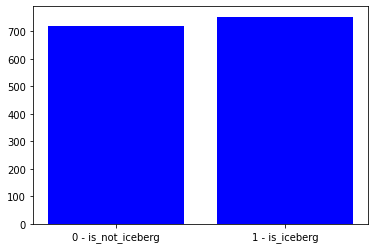

In [17]:
fig = plt.figure()

is_iceberg = train[(train['is_iceberg']==0)]['id'].count()
is_not_iceberg = train[(train['is_iceberg']==1)]['id'].count()

label = ['0 - is_not_iceberg', '1 - is_iceberg']
data = [is_iceberg,is_not_iceberg]

plt.bar(label, data,color='b')
plt.show()

Dataset is balanced

### Inc Angle exploration

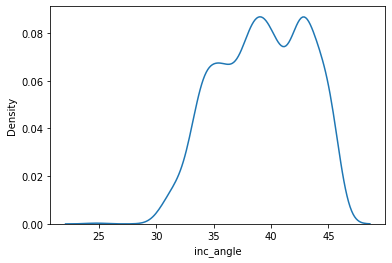

In [18]:
import seaborn as sns

sns.distplot(train['inc_angle'],hist=False, bins=10);

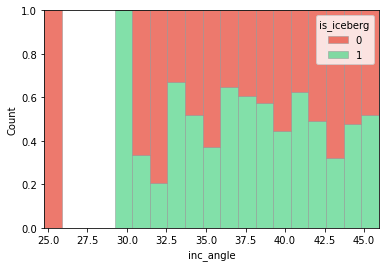

In [19]:
#inc_angle vs is_iceberg Plot
sns.histplot(
    data = train,
    x = 'inc_angle', hue = 'is_iceberg',
    multiple = 'fill',
    palette = sns.color_palette(['#E74C3C', '#58D68D']),
    edgecolor = '.6',
    linewidth = .5
)

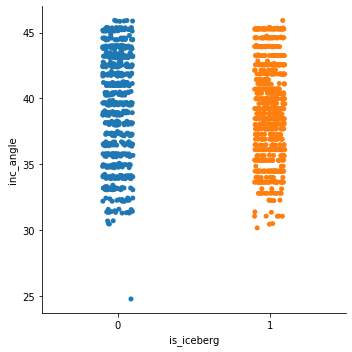

In [20]:
sns.catplot(x="is_iceberg", y="inc_angle", data=train);

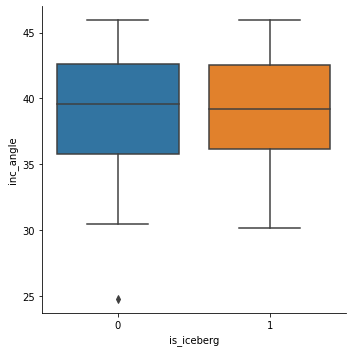

In [21]:
sns.catplot(x="is_iceberg", y="inc_angle", kind="box", data=train);

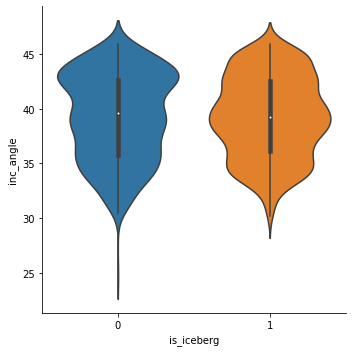

In [22]:
sns.catplot(x="is_iceberg", y="inc_angle", kind="violin", data=train);

### Images visualization

Some examples. We can modify *band* and number of images to show

[[-20.04884  -19.469616 -20.510244 ... -21.34148  -20.203434 -21.169577]
 [-20.199951 -22.448444 -19.61095  ... -20.673006 -18.17428  -19.757956]
 [-18.292282 -19.754473 -18.540565 ... -18.418921 -17.704659 -19.903938]
 ...
 [-23.496841 -19.194586 -19.4704   ... -15.676193 -14.653192 -17.369173]
 [-20.354424 -20.049671 -22.254032 ... -18.055161 -16.940105 -15.767244]
 [-20.354424 -20.998165 -22.063126 ... -22.257366 -21.170263 -17.591902]]


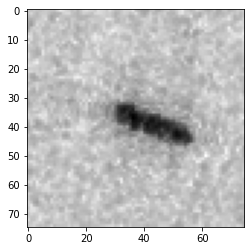

In [23]:
image = np.array(train.loc[100,'band_1'])
image = image.reshape(75,75)
print(image)

plt.imshow(image, cmap=plt.get_cmap('gray_r'))

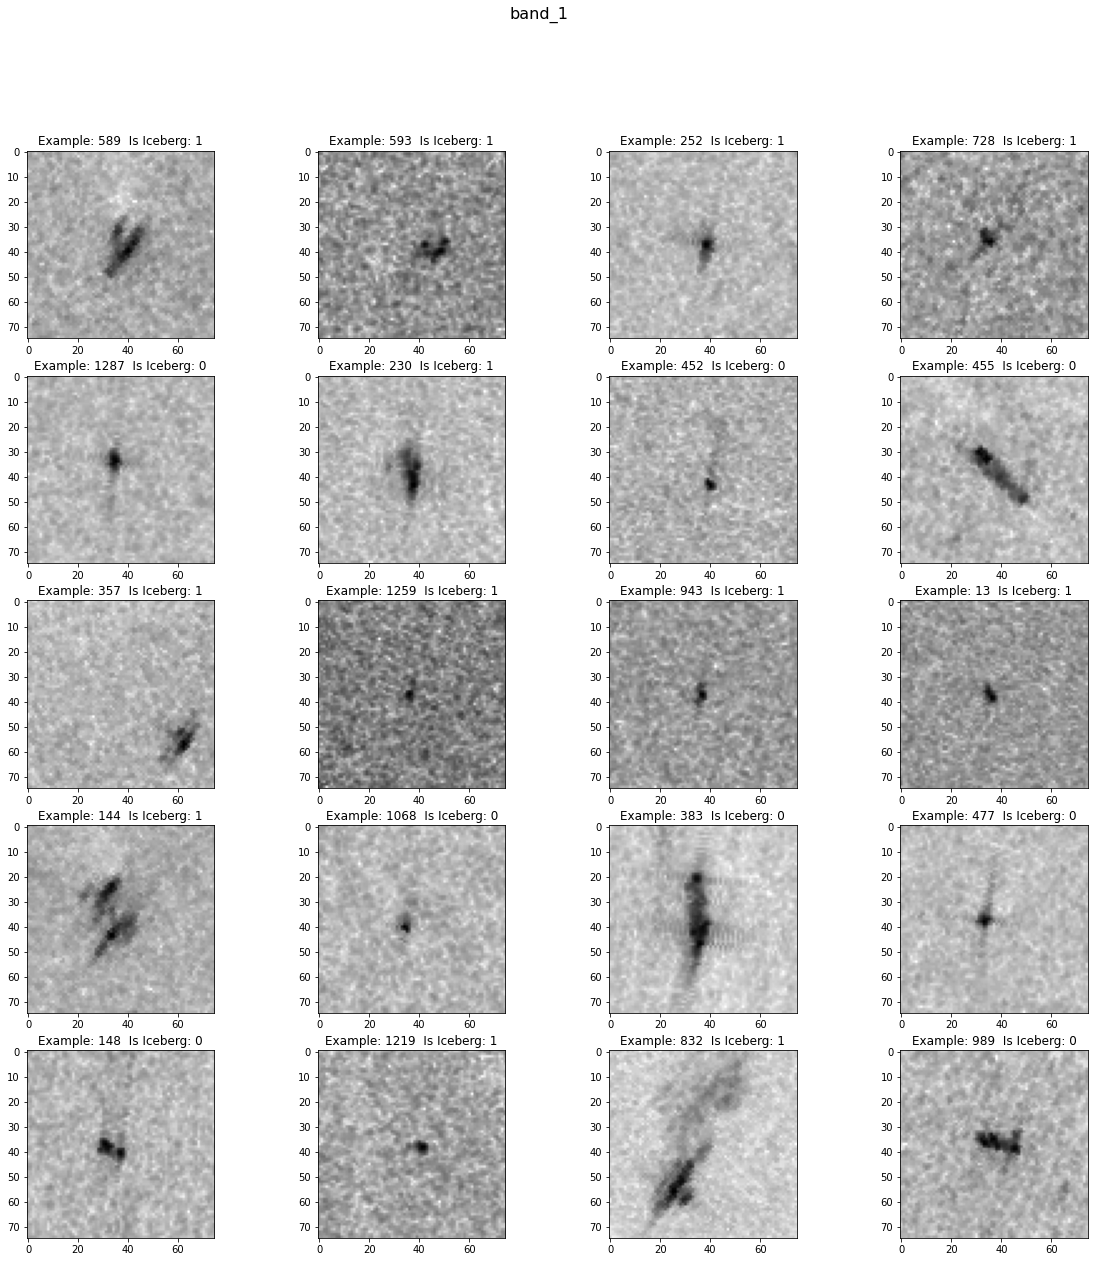

In [24]:
def plot_images(num, band):
  '''
  Plot num images of band column from train dataframe
  '''
  image = np.array(train.loc[num, band])
  label = np.array(train.loc[num, 'is_iceberg'])
  image = image.reshape(75, 75)

  plt.title('Example: %d  Is Iceberg: %d' % (num, label))
  plt.imshow(image, cmap=plt.get_cmap('gray_r'))

h = 10
w = 10
band = 'band_1'
cols = 4
rows = 5
fig = plt.figure(figsize=(20, 20))
fig.suptitle(band, fontsize=16)

for i in range(1, cols*rows +1):
    fig.add_subplot(rows, cols, i)

    aa = np.random.randint(0, train.shape[0])
    plot_images(aa, band)
    
plt.show()

Now we are going to plot de same image from diffrents bands

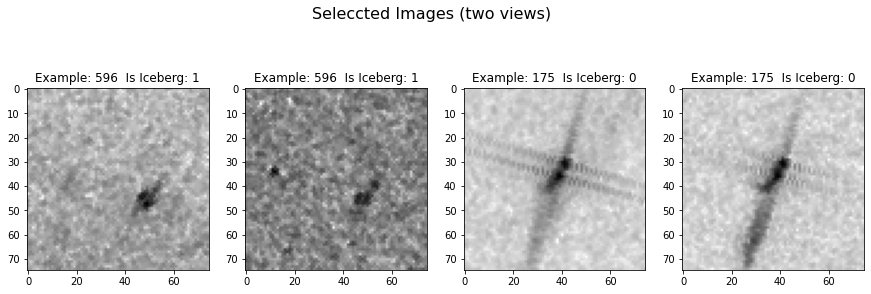

In [25]:
cols = 4
rows = 1
fig = plt.figure(figsize=(15, 5))
fig.suptitle('Seleccted Images (two views)', fontsize=16)

for i in range(1, cols*rows+1):
    if i < 3:
      img = 596
    else:
      img = 175
    if i%2 != 0:
      band = 'band_1'
    else:
      band = 'band_2'
    fig.add_subplot(rows, cols, i)
    plot_images(img, band)
plt.show()

# Data processing

We compose the two bands of each photo. This will allows us to generate and additional sinthetical view

Therefore, we concatenate in X the three available photos, band-1, band_2 and the one composed as a semi-sum of both

In [26]:
X_band_1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train['band_1']])
X_band_2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train['band_2']])

X = np.concatenate([X_band_1[:, :, :, np.newaxis], X_band_2[:, :, :, np.newaxis], ((X_band_1 + X_band_2) / 2)[:, :, :, np.newaxis]], axis=-1)
y = train['is_iceberg']

print(X_band_2.shape)
print(X.shape)

(1471, 75, 75)
(1471, 75, 75, 3)


In [27]:
print(X_band_1[1])
print(X[1,:,:,2])

[[-12.242375 -14.920305 -14.920363 ... -10.633402 -11.956054 -14.379026]
 [-13.046626 -14.077841 -12.728542 ... -11.243189 -11.786291 -14.379026]
 [-15.248114 -14.0779   -12.604514 ... -15.680162 -13.51685  -14.454887]
 ...
 [-15.589596 -16.899685 -17.527912 ... -11.78711  -10.883234 -12.306804]
 [-14.761801 -15.503286 -15.333027 ...  -9.793052  -8.062263  -9.882715]
 [-13.178177 -15.503286 -14.375814 ... -11.087559  -8.246684  -8.666801]]
[[-21.874348 -21.45243  -20.78302  ... -18.199516 -18.211464 -19.934505]
 [-19.266174 -19.51852  -19.53471  ... -19.800749 -19.887497 -20.072388]
 [-19.977768 -21.216091 -19.325493 ... -20.585014 -20.083307 -22.47121 ]
 ...
 [-21.787483 -21.77309  -21.7876   ... -19.540693 -20.016327 -19.8006  ]
 [-22.165428 -21.5671   -20.14661  ... -17.130373 -16.030197 -17.824673]
 [-20.95969  -20.23171  -20.358814 ... -19.027014 -16.735104 -16.94519 ]]


Now we are going to represent in 3D either the Ship and Iceberg views. 

In [28]:
# Import the library PLOTLY
import plotly.offline as py
import plotly.graph_objs as go
from plotly import subplots

def plt_contour_2d(band1, band2, band3, label, num):
    fig = subplots.make_subplots(rows=1, cols=3, specs=[[{'is_3d': True}, {'is_3d':True}, {'is_3d':True}]])
    fig.append_trace(dict(type='surface', z=band1, colorscale='RdBu_r',
                          scene='scene1', showscale=False), 1, 1)
    fig.append_trace(dict(type='surface', z=band2, colorscale='RdBu_r',
                          scene='scene2', showscale=False), 1, 2)
    fig.append_trace(dict(type='surface', z=band3, colorscale='RdBu_r',
                          scene='scene2', showscale=False), 1, 3)
    
    fig['layout'].update(title='3D plot for "{}" (left band1, center band2, right band3 sinthetic)'.format(label), 
                         titlefont=dict(size=25), height=600, width=800)
    py.iplot(fig)
    
    fig, ax = plt.subplots(1,3,figsize=(14,5))
    ax[0].imshow(X[num,:,:,0], cmap=plt.get_cmap('gray_r'))
    ax[0].set_title('Image band_1', fontsize=15)
    
    ax[1].imshow(X[num,:,:,1], cmap=plt.get_cmap('gray_r'))
    ax[1].set_title('Image band_2', fontsize=15)
    
    ax[2].imshow(X[num,:,:,2], cmap=plt.get_cmap('gray_r'))
    ax[2].set_title('Image band_3 Sinthetic', fontsize=15)
    
    plt.show()

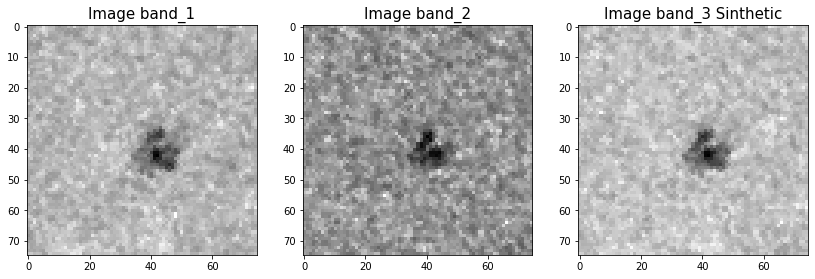

In [29]:
def plt_sample(dataset, num):
  label = 'iceberg' if (y.iloc[num] == 1) else'ship'
  plt_contour_2d(dataset[num,:,:,0], dataset[num,:,:,1], dataset[num,:,:,2], label, num)

plt_sample(X, 572)

Let's now see the result of the combination of the two bands for the selected photo

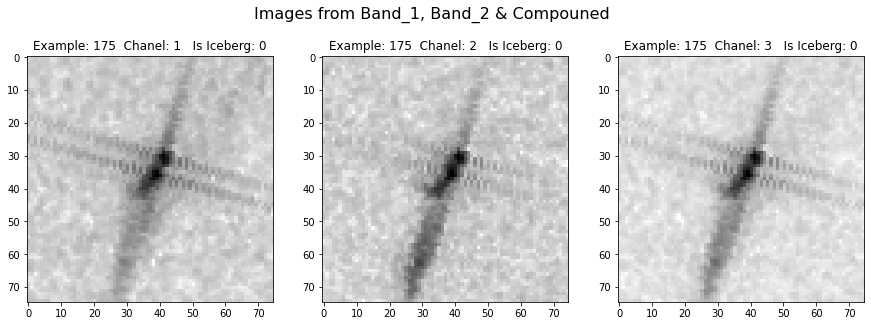

In [30]:
cols = 3
rows = 1
fig = plt.figure(figsize=(15, 5))
fig.suptitle("Images from Band_1, Band_2 & Compouned", fontsize=16)
img = 175
label = np.array(y.loc[img])

for i in range(1, cols+1):
    image = X[img,:,:,i-1]
    fig.add_subplot(rows, cols, i)
       
    plt.imshow(image, cmap=plt.get_cmap('gray_r'))
    plt.title('Example: %d  Chanel: %i   Is Iceberg: %i' % (img, i, label))

plt.show()

### Data Augmentation

Data augmentation have not demostrated any improve avoiding overfitting

In [31]:
'''from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=60, # grados de rotacion aleatoria
    width_shift_range=0.2, # fraccion del total (1) para mover la imagen
    height_shift_range=0.2, # fraccion del total (1) para mover la imagen
    horizontal_flip=True, # girar las imagenes horizontalmente (eje vertical)
    vertical_flip=True, # girar las imagenes verticalmente (eje horizontal)
    zoom_range=0.2, # rango de zoom
    fill_mode='nearest', # como rellenar posibles nuevos pixeles
    # channel_shift_range=0.2 # cambios aleatorios en los canales de la imagen
)'''

"from tensorflow.keras.preprocessing.image import ImageDataGenerator\n\ndatagen = ImageDataGenerator(\n    rotation_range=60, # grados de rotacion aleatoria\n    width_shift_range=0.2, # fraccion del total (1) para mover la imagen\n    height_shift_range=0.2, # fraccion del total (1) para mover la imagen\n    horizontal_flip=True, # girar las imagenes horizontalmente (eje vertical)\n    vertical_flip=True, # girar las imagenes verticalmente (eje horizontal)\n    zoom_range=0.2, # rango de zoom\n    fill_mode='nearest', # como rellenar posibles nuevos pixeles\n    # channel_shift_range=0.2 # cambios aleatorios en los canales de la imagen\n)"

In [32]:
'''from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline


def get_augmentation(generator, n_augmentations, item):
  sample = item

  
  it = datagen.flow(X[sample].reshape((1,75,75,3)),batch_size=1)
  augmentations = np.arange(n_augmentations*75*75*3).reshape(n_augmentations, 75, 75, 3)

  for i in range(3):
    batch = it.next()
    augmentations[i] = batch[0]

  return augmentations'''

'from tensorflow.keras.preprocessing import image\nimport matplotlib.pyplot as plt\n%matplotlib inline\n\n\ndef get_augmentation(generator, n_augmentations, item):\n  sample = item\n\n  \n  it = datagen.flow(X[sample].reshape((1,75,75,3)),batch_size=1)\n  augmentations = np.arange(n_augmentations*75*75*3).reshape(n_augmentations, 75, 75, 3)\n\n  for i in range(3):\n    batch = it.next()\n    augmentations[i] = batch[0]\n\n  return augmentations'

In [33]:
'''for i in range(0, X.shape[0]):
  if(i%100 == 0): print(i,'de', X_band_1.shape[0]-1)
  for j in range(X.shape[0], X.shape[0]+3):
    y[j] = y[i]
  gen = get_augmentation(datagen, 3, i)
  X = np.vstack((X, gen))

print(X.shape)
print(y.shape)'''

"for i in range(0, X.shape[0]):\n  if(i%100 == 0): print(i,'de', X_band_1.shape[0]-1)\n  for j in range(X.shape[0], X.shape[0]+3):\n    y[j] = y[i]\n  gen = get_augmentation(datagen, 3, i)\n  X = np.vstack((X, gen))\n\nprint(X.shape)\nprint(y.shape)"

### Standarization & train-test-val split

Now we are ready for spliting the data in training and test sets

In order to easy the model processing, the data will be normalized between 0 and 1

In [34]:
from sklearn.model_selection import train_test_split

# Normalización de los datos a 0/1.
X_1 = X/255.0
X_2 = (X - np.min(X))/np.ptp(X)

# Data partition coefficient (80% Training / 20% Test)
niv_div = 0.2

# FIRST DIVISION - Split in Trainning data and Test data
X_train, X_test, y_train, y_test = train_test_split(X_2, y, random_state=42, test_size=niv_div)

# SECOND DIVISIÓN - Split de Training data in Training data and Validation data
X_trn, X_val, y_trn, y_val = train_test_split(X_train, y_train, random_state=42, test_size=niv_div)

print('Training Data -',X_train.shape[0])
print('Test Data -',X_test.shape[0])

Training Data - 1176
Test Data - 295


# Strategy 1

## Neural network topology and fitting

In [35]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.layers import GlobalMaxPooling2D
# from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import optimizers
from keras import initializers
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

# GENERACIÓN DE LA ESTRUCTURA DE CNN
def model():

    # BASE MODEL -------
    modicbrg = Sequential()
    
    modicbrg.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(75, 75, 3)))
    modicbrg.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    # modicbrg.add(Dropout(0.2))
    
    modicbrg.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    modicbrg.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    # modicbrg.add(Dropout(0.2))
    
    modicbrg.add(Conv2D(164, kernel_size=(3, 3), activation='relu'))
    modicbrg.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    # modicbrg.add(Dropout(0.2))

    # TOP MODEL --------
    modicbrg.add(Flatten())

    modicbrg.add(Dense(64))
    modicbrg.add(Activation('relu'))
    modicbrg.add(Dropout(0.2))
    
    modicbrg.add(Dense(32))
    modicbrg.add(Activation('relu'))
    modicbrg.add(Dropout(0.2))
    
    modicbrg.add(Dense(8))
    modicbrg.add(Activation('relu'))
    modicbrg.add(Dropout(0.2))
    
    modicbrg.add(Dense(1))
    modicbrg.add(Activation('sigmoid'))


    modicbrg.summary()

    # Model Compilation
    # optimizers.adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08, name='adam')
    modicbrg.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])
    
    return modicbrg 


In [36]:
def get_callbacks(filepath, patience):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]

file_path = ".model_weights.hdf5"
callbacks = get_callbacks(filepath=file_path, patience=3)

## Training monitoring

In [37]:
# Training process 
n_epochs = 65
modicbrg = model()

# NOTE - Given the great variability of the Accuracy and Loss values ​​that the network presents throughout
# the training process, the use of EarlyStopping is not recommended
H = modicbrg.fit(X_trn, y_trn, epochs=n_epochs, batch_size=128, validation_data=(X_val, y_val))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 73, 73, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 36, 36, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 17, 17, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 15, 164)       189092    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 7, 7, 164)        0

## Testing and performance

In order to see the presence of overfitting, we will analize the accuracy and losses graph 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

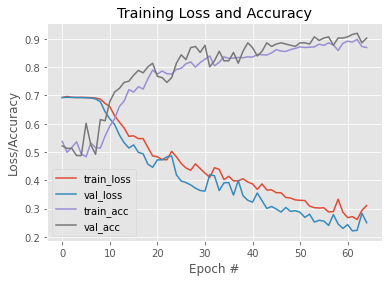

In [38]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, n_epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, n_epochs), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, n_epochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, n_epochs), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

# Guardamos la Figura
import os
# print( os.getcwd() )
# print( os.listdir() )
nom_fig = 'model_00.png'
plt.savefig(nom_fig,format='png',bbox_inches = "tight")
files.download( nom_fig ) 

In [39]:
print(X_test.shape)
print(y_test.shape)

(295, 75, 75, 3)
(295,)


In [40]:
score = modicbrg.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10/10 [==============================] - 2s 184ms/step - loss: 0.3211 - accuracy: 0.8712
Test loss: 0.3211444020271301
Test accuracy: 0.8711864352226257


In [41]:
def get_sample_plt_and_predict(num, predictor):
  predict = predictor.predict(X_test[num-1:num,:,:,:])
  print('Ship probability: ', 1-predict)
  print('Iceberg probability: ', predict,'\n')

  print('Label value: ', y_test[num-1:num].item())
  if y_test[num-1:num].item() == 0:
    print('It is a Ship\n')
  else:
    print('It is an Iceberg\n')

  #plt_sample(X_test, num)

  image = np.array(X_test[num-1:num,:,:,0])
  image = image.reshape(75,75)
  plt.imshow(image, cmap=plt.get_cmap('gray_r'))


Ship probability:  [[0.15584242]]
Iceberg probability:  [[0.8441576]] 

Label value:  1
It is an Iceberg



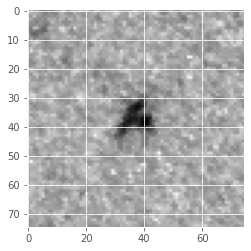

In [42]:
# Verificar PREDICCIONES
num = 204

tope = y_test.shape
if num < tope[0]:
  get_sample_plt_and_predict(num, modicbrg)

# Strategy 2

## Neural network topology

In [43]:
# Import the necessary packages
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.metrics import classification_report
from google.colab import drive
from tensorflow.keras.applications import InceptionV3, VGG16
from tensorflow.keras import layers


### InceptionV3

In [44]:
base_model_inceptionv3_tl = InceptionV3(weights='imagenet', include_top=False,input_shape=(75,75,3))
base_model_inceptionv3_tl.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 37, 37, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 37, 37, 32)  96          ['conv2d_3[0][0]']               
 alization)                                                                                       
                                                                                                  
 activation_4 (Activation)      (None, 37, 37, 32)   0           ['batch_normalization[

In [45]:
base_model_inceptionv3_tl.trainable = False
pre_trained_model_inceptionv3_tl = Sequential()

pre_trained_model_inceptionv3_tl.add(base_model_inceptionv3_tl)

pre_trained_model_inceptionv3_tl.add(Flatten())

pre_trained_model_inceptionv3_tl.add(Dense(512))
pre_trained_model_inceptionv3_tl.add(Activation('relu'))
pre_trained_model_inceptionv3_tl.add(Dropout(0.5))

pre_trained_model_inceptionv3_tl.add(Dense(1))
pre_trained_model_inceptionv3_tl.add(Activation('sigmoid'))


pre_trained_model_inceptionv3_tl.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               1049088   
                                                                 
 activation_98 (Activation)  (None, 512)               0         
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 513       
                                                                 
 activation_99 (Activation)  (None, 1)                

### VGG16

In [46]:
base_model_vgg16_tl = VGG16(weights='imagenet', include_top=False,input_shape=(75,75,3))
base_model_vgg16_tl.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 75, 75, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 75, 75, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 37, 37, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 37, 37, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 37, 37, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 18, 18, 128)       0     

In [47]:
base_model_vgg16_tl.trainable = False
pre_trained_model_vgg16_tl = Sequential()

pre_trained_model_vgg16_tl.add(base_model_inceptionv3_tl)

pre_trained_model_vgg16_tl.add(Flatten())

pre_trained_model_vgg16_tl.add(Dense(512))
pre_trained_model_vgg16_tl.add(Activation('relu'))
pre_trained_model_vgg16_tl.add(Dropout(0.5))

pre_trained_model_vgg16_tl.add(Dense(1))
pre_trained_model_vgg16_tl.add(Activation('sigmoid'))


pre_trained_model_vgg16_tl.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               1049088   
                                                                 
 activation_100 (Activation)  (None, 512)              0         
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 513       
                                                                 
 activation_101 (Activation)  (None, 1)               

## Training monitoring

In [48]:
drive.mount('/content/drive') 

BASE_FOLDER = '/content/drive/MyDrive/Master IA/Deep Learning /Trabajo de programacion/'

labelNames = ["Ship","Iceberg"]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### InceptionV3

In [49]:
# Compilar el modelo
print("[INFO]: Compilando el modelo...")
pre_trained_model_inceptionv3_tl.compile(loss="binary_crossentropy", optimizer=Adam(lr=0.0001,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08), metrics=["accuracy"]) 

# Entrenamiento de la red
print("[INFO]: Entrenando el modelo...")
H_pre_inceptionv4_tl = pre_trained_model_inceptionv3_tl.fit(X_train, y_train, batch_size=128, epochs=30, validation_split=0.15)

# Almacenamos el modelo empleando la función mdoel.save de Keras
pre_trained_model_inceptionv3_tl.save(BASE_FOLDER+"inceptionv3_tl_pretrained.h5")

[INFO]: Compilando el modelo...
[INFO]: Entrenando el modelo...
Epoch 1/30
8/8 [==============================] - 16s 1s/step - loss: 0.7697 - accuracy: 0.5475 - val_loss: 0.6253 - val_accuracy: 0.6441
Epoch 2/30
8/8 [==============================] - 9s 1s/step - loss: 0.6319 - accuracy: 0.6587 - val_loss: 0.5656 - val_accuracy: 0.7119
Epoch 3/30
8/8 [==============================] - 9s 1s/step - loss: 0.5792 - accuracy: 0.6927 - val_loss: 0.5357 - val_accuracy: 0.7401
Epoch 4/30
8/8 [==============================] - 9s 1s/step - loss: 0.5524 - accuracy: 0.7197 - val_loss: 0.5110 - val_accuracy: 0.7740
Epoch 5/30
8/8 [==============================] - 9s 1s/step - loss: 0.5050 - accuracy: 0.7648 - val_loss: 0.5021 - val_accuracy: 0.7627
Epoch 6/30
8/8 [==============================] - 9s 1s/step - loss: 0.4938 - accuracy: 0.7648 - val_loss: 0.4986 - val_accuracy: 0.7571
Epoch 7/30
8/8 [==============================] - 9s 1s/step - loss: 0.4683 - accuracy: 0.7778 - val_loss: 0.4904

### VGG16

In [50]:
# Compilar el modelo
print("[INFO]: Compilando el modelo...")
pre_trained_model_vgg16_tl.compile(loss="binary_crossentropy", optimizer=Adam(lr=0.0001,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08), metrics=["accuracy"]) 

# Entrenamiento de la red
print("[INFO]: Entrenando el modelo...")
H_pre_vgg16_tl = pre_trained_model_vgg16_tl.fit(X_train, y_train, batch_size=128, epochs=30, validation_split=0.15)

# Almacenamos el modelo empleando la función mdoel.save de Keras
pre_trained_model_vgg16_tl.save(BASE_FOLDER+"vgg16_tl_pretrained.h5") #(X)

[INFO]: Compilando el modelo...
[INFO]: Entrenando el modelo...
Epoch 1/30
8/8 [==============================] - 16s 1s/step - loss: 0.8034 - accuracy: 0.5485 - val_loss: 0.6138 - val_accuracy: 0.6384
Epoch 2/30
8/8 [==============================] - 9s 1s/step - loss: 0.6874 - accuracy: 0.6436 - val_loss: 0.5653 - val_accuracy: 0.7006
Epoch 3/30
8/8 [==============================] - 9s 1s/step - loss: 0.6139 - accuracy: 0.6837 - val_loss: 0.5413 - val_accuracy: 0.7175
Epoch 4/30
8/8 [==============================] - 10s 1s/step - loss: 0.5549 - accuracy: 0.7217 - val_loss: 0.5241 - val_accuracy: 0.7232
Epoch 5/30
8/8 [==============================] - 9s 1s/step - loss: 0.5311 - accuracy: 0.7337 - val_loss: 0.5223 - val_accuracy: 0.7232
Epoch 6/30
8/8 [==============================] - 9s 1s/step - loss: 0.4796 - accuracy: 0.7678 - val_loss: 0.5079 - val_accuracy: 0.7514
Epoch 7/30
8/8 [==============================] - 9s 1s/step - loss: 0.4717 - accuracy: 0.7728 - val_loss: 0.502

## Testing and performance

### InceptionV3

[INFO]: Evaluando el modelo...
              precision    recall  f1-score   support

        Ship       0.83      0.83      0.83       139
     Iceberg       0.85      0.85      0.85       156

    accuracy                           0.84       295
   macro avg       0.84      0.84      0.84       295
weighted avg       0.84      0.84      0.84       295



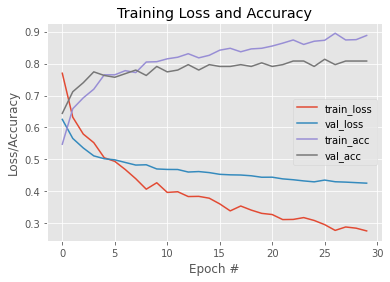

In [51]:
# Evaluación del modelo
print("[INFO]: Evaluando el modelo...")

# Efectuamos la predicción (empleamos el mismo valor de batch_size que en training)
predictions_inceptionv3_tl = pre_trained_model_inceptionv3_tl.predict(X_test, batch_size=128)

# Sacamos el report para test
print(classification_report(y_test, predictions_inceptionv3_tl.round(), target_names=labelNames)) 

# Gráficas
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 30), H_pre_inceptionv4_tl.history["loss"], label="train_loss")
plt.plot(np.arange(0, 30), H_pre_inceptionv4_tl.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 30), H_pre_inceptionv4_tl.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 30), H_pre_inceptionv4_tl.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

In [52]:
score = pre_trained_model_inceptionv3_tl.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10/10 [==============================] - 3s 319ms/step - loss: 0.3791 - accuracy: 0.8373
Test loss: 0.37910062074661255
Test accuracy: 0.8372881412506104


Ship probability:  [[0.00534064]]
Iceberg probability:  [[0.99465936]] 

Label value:  1
It is an Iceberg



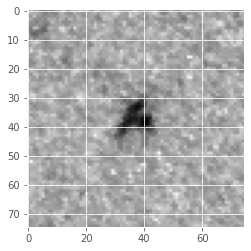

In [53]:
# Verificar PREDICCIONES
num = 204

tope = y_test.shape
if num < tope[0]:
  get_sample_plt_and_predict(num, pre_trained_model_inceptionv3_tl)

### VGG16

[INFO]: Evaluando el modelo...
              precision    recall  f1-score   support

        Ship       0.79      0.82      0.81       139
     Iceberg       0.83      0.81      0.82       156

    accuracy                           0.81       295
   macro avg       0.81      0.81      0.81       295
weighted avg       0.81      0.81      0.81       295



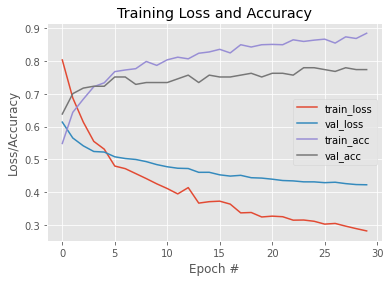

In [54]:
# Evaluación del modelo
print("[INFO]: Evaluando el modelo...")

# Efectuamos la predicción (empleamos el mismo valor de batch_size que en training)
predictions_vgg16_tl = pre_trained_model_vgg16_tl.predict(X_test, batch_size=128)

# Sacamos el report para test
print(classification_report(y_test, predictions_vgg16_tl.round(), target_names=labelNames)) 

# Gráficas
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 30), H_pre_vgg16_tl.history["loss"], label="train_loss")
plt.plot(np.arange(0, 30), H_pre_vgg16_tl.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 30), H_pre_vgg16_tl.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 30), H_pre_vgg16_tl.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

In [55]:
score = pre_trained_model_vgg16_tl.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10/10 [==============================] - 3s 309ms/step - loss: 0.3782 - accuracy: 0.8136
Test loss: 0.3782418668270111
Test accuracy: 0.8135592937469482


Ship probability:  [[0.00318652]]
Iceberg probability:  [[0.9968135]] 

Label value:  1
It is an Iceberg



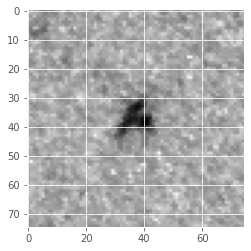

In [56]:
# Verificar PREDICCIONES
num = 204

tope = y_test.shape
if num < tope[0]:
  get_sample_plt_and_predict(num, pre_trained_model_vgg16_tl)

# Discusión